In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

train_dir = "데이터셋/한국인 감정인식을 위한 복합 영상/최종 데이터셋/train"
val_dir = "데이터셋/한국인 감정인식을 위한 복합 영상/최종 데이터셋/val"
test_dir = "데이터셋/한국인 감정인식을 위한 복합 영상/최종 데이터셋/test"
 
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 58487 images belonging to 5 classes.
Found 12533 images belonging to 5 classes.
Found 12534 images belonging to 5 classes.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.applications import EfficientNetB0 

base_model = EfficientNetB0(include_top=False,
                            weights= None,
                            input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)

predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

In [4]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_path = "effb0_final.hdf5"
checkpoint_cb = ModelCheckpoint(checkpoint_path, verbose=1, save_best_only=True,monitor='val_loss')
early_stop_cb = EarlyStopping(patience=10,restore_best_weights=True)

In [5]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=300,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[checkpoint_cb,early_stop_cb])

Epoch 1/300
1827/1827 [==============================] - ETA: 0s - loss: 0.8708 - accuracy: 0.6527
Epoch 1: val_loss improved from inf to 0.54186, saving model to effb0_final.hdf5
1827/1827 [==============================] - 384s 204ms/step - loss: 0.8708 - accuracy: 0.6527 - val_loss: 0.5419 - val_accuracy: 0.8205
Epoch 2/300
1827/1827 [==============================] - ETA: 0s - loss: 0.4198 - accuracy: 0.8563
Epoch 2: val_loss improved from 0.54186 to 0.51204, saving model to effb0_final.hdf5
1827/1827 [==============================] - 331s 181ms/step - loss: 0.4198 - accuracy: 0.8563 - val_loss: 0.5120 - val_accuracy: 0.8346
Epoch 3/300
1827/1827 [==============================] - ETA: 0s - loss: 0.3504 - accuracy: 0.8796
Epoch 3: val_loss improved from 0.51204 to 0.33310, saving model to effb0_final.hdf5
1827/1827 [==============================] - 351s 192ms/step - loss: 0.3504 - accuracy: 0.8796 - val_loss: 0.3331 - val_accuracy: 0.8872
Epoch 4/300
1827/1827 [==================

In [6]:
model.evaluate(test_generator)


392/392 [==============================] - 28s 72ms/step - loss: 0.2589 - accuracy: 0.9172


[0.25891363620758057, 0.9171852469444275]

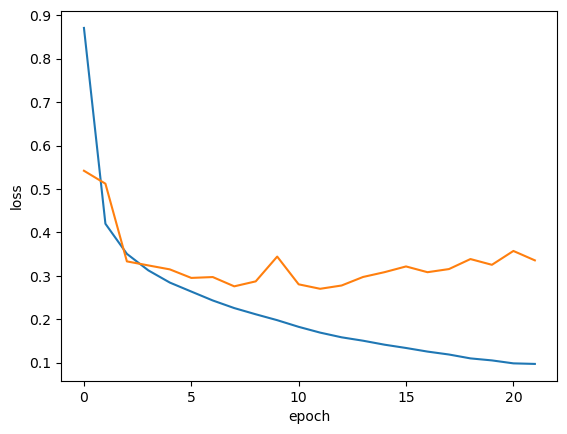

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")

plt.show()

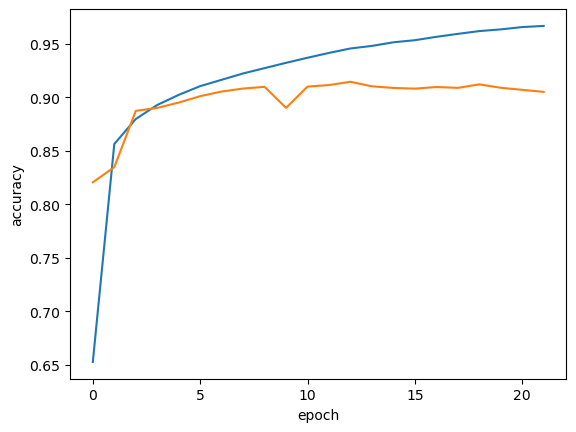

In [8]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

392/392 [==============================] - 22s 53ms/step


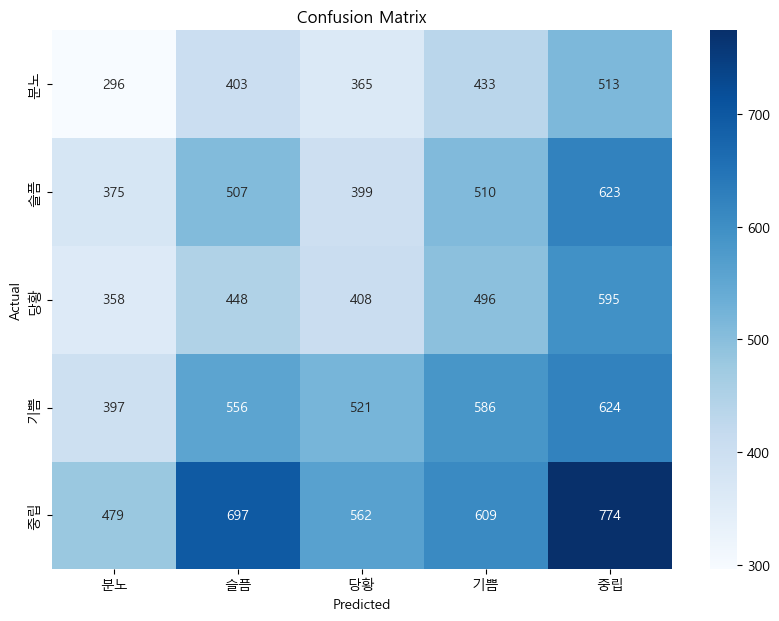

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
predictions = model.predict(test_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_generator.classes
emotions_korean = ["분노", "슬픔", "당황", "기쁨", "중립"]

cm = confusion_matrix(y_test, y_pred)
plt.rcParams['font.family'] = 'Malgun Gothic'

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions_korean, yticklabels=emotions_korean)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()